# Macular Degeneration Classifier (CaiT+MLP)

### Package Installations

In [1]:
## Uncomment the following if you do not have them installed already. 
# pip install torch torchvision
# pip install skorch
# pip install scikit-learn
# pip install matplotlib seaborn
# pip install pandas
# pip install pillow

## Only uncomment this if you need to do an update for skorch
# !pip install -U skorch

### Loading Libraries

In [2]:
# basic libraries
import time
import random
import ntpath
import glob
import os
import csv
import numpy as np
import pandas as pd
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, models, transforms, utils

# skorch libraries
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler, Checkpoint, Freezer
from skorch.callbacks import EpochScoring
from skorch.callbacks import EarlyStopping

# scikit-learn libraries
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

### Experiment Name

In [3]:
NAME_OF_EXPERIMENT = "OCT CaiT + New MLP"

### Function for creating data CSV files containing paths and labels

In [4]:
import os
import csv

def create_csv(output_csv_path, dataset_root, label_mapping):
    """
    Create a CSV file containing image paths and their corresponding labels.

    Args:
    - output_csv_path (str): The path to save the output CSV file.
    - dataset_root (str): The root directory of the dataset.
    - label_mapping (dict): A dictionary mapping label names to label indices.

    Returns:
    - None
    """

    # Open the CSV file for writing
    with open(output_csv_path, 'w', newline='') as csvfile:
        # Create a CSV writer
        csv_writer = csv.writer(csvfile)

        # Write the header row
        csv_writer.writerow(['path', 'label'])

        # Traverse the dataset root and write each image path and label to the CSV file
        for root, dirs, files in os.walk(dataset_root):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    # Extract the label from the directory name
                    label = os.path.basename(root)
                    
                    # Check if the label is in the label mapping
                    if label in label_mapping:
                        # Write the image path and label to the CSV file
                        path = os.path.relpath(os.path.join(root, file), dataset_root)
                        csv_writer.writerow([path, label_mapping.get(label, label)])

    print(f"data CSV file created: {output_csv_path}")



### Creating csv files for training and validation sets

In [5]:
# Using function to create a csv file
dataset_root = './archive/OCT_Balanced_Version/Balanced'  #TODO: Path to the actual location of the dataset
output_csv_path = 'train_and_validation_data.csv'
label_mapping = {'NORMAL': 0, 'CNV': 1, 'DRUSEN': 2, 'DME': 3}

create_csv(output_csv_path, dataset_root, label_mapping)


data CSV file created: train_and_validation_data.csv


### Creating csv files for test set

In [6]:
# Using function to create a csv file
dataset_root = './archive/test/test'  #TODO: Path to the actual location of the dataset
output_csv_path = 'test_data.csv' 
label_mapping = {'NORMAL': 0, 'CNV': 1, 'DRUSEN': 2, 'DME': 3} 

create_csv(output_csv_path, dataset_root, label_mapping)


data CSV file created: test_data.csv


### Function to read CSV file

In [7]:
import pandas as pd

def read_data_csv(csv_file, dataset_root, class_names):
    """
    Read the data CSV file, make image paths relative, store the number of classes,
    and define class names.

    Args:
    - csv_file (str): The path to the data CSV file.
    - dataset_root (str): The root directory of the dataset.
    - class_names (list): A list of class names.

    Returns:
    - data (pd.DataFrame): DataFrame containing the data from the CSV file.
    - NUMBER_OF_CLASSES (int): Number of unique classes.
    """

    # Reading the data CSV file
    data = pd.read_csv(csv_file)

    # Making image path relative
    data['path'] = dataset_root + '/' + data['path'].str.replace('\\', '/', regex=True)

    # Storing the number of classes
    NUMBER_OF_CLASSES = len(class_names)

    # Displaying the first few rows
    print(data.head())

    return data, NUMBER_OF_CLASSES



### Reading the data csv files

In [8]:
# Using function to read the data CSV file
csv_file = "train_and_validation_data.csv"
dataset_root = './archive/OCT_Balanced_Version/Balanced'  #TODO: Path to the actual location of the dataset
class_names = ['DME', 'CNV', 'DRUSEN', 'NORMAL'] 

data, NUMBER_OF_CLASSES = read_data_csv(csv_file, dataset_root, class_names)


                                                path  label
0  ./archive/OCT_Balanced_Version/Balanced/CNV/CN...      1
1  ./archive/OCT_Balanced_Version/Balanced/CNV/CN...      1
2  ./archive/OCT_Balanced_Version/Balanced/CNV/CN...      1
3  ./archive/OCT_Balanced_Version/Balanced/CNV/CN...      1
4  ./archive/OCT_Balanced_Version/Balanced/CNV/CN...      1


In [9]:
# Using function to read the data CSV file
csv_file = "test_data.csv" 
dataset_root = './archive/test/test'  #TODO: Path to the actual location of the dataset
class_names = ['DME', 'CNV', 'DRUSEN', 'NORMAL'] 

test_data, NUMBER_OF_CLASSES = read_data_csv(csv_file, dataset_root, class_names)


                                         path  label
0  ./archive/test/test/CNV/CNV-1016042-1.jpeg      1
1  ./archive/test/test/CNV/CNV-1016042-2.jpeg      1
2  ./archive/test/test/CNV/CNV-1016042-3.jpeg      1
3  ./archive/test/test/CNV/CNV-1016042-4.jpeg      1
4   ./archive/test/test/CNV/CNV-103044-1.jpeg      1


## Checking the distribution of the following classes

'NORMAL': 0

'CNV': 1

'DRUSEN': 2

'DME': 3

In [10]:
# checking the distribution of classes
data.label.value_counts()

1    8016
3    8016
0    8016
2    8015
Name: label, dtype: int64

In [11]:
# checking the distribution of classes
test_data.label.value_counts()

1    242
3    242
2    242
0    242
Name: label, dtype: int64

## Dataset Class

In [13]:
class Dataset_Loader(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X.reset_index().drop('index', axis=1).path
        self.y = torch.tensor(y.reset_index().drop('index', axis=1).label, dtype=torch.long)
        self.transform = transform

        assert len(self.X) == len(self.y), f'X and y have different lengths -> {len(self.X)} != {len(self.y)} '

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        img = Image.open(img_path)

        # Convert grayscale to RGB if the image is grayscale
        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[idx]
        return (img, label)
    
    def show_img(self, idx):
        '''Plot image'''
        img, label = self.__getitem__(idx)
        if img is not None:
            # Normalize pixel values to [0, 1] range
            img = img.numpy().transpose((1, 2, 0))
            img = (img - img.min()) / (img.max() - img.min())
            plt.figure(figsize=(16, 8))
            plt.axis('off')
            plt.imshow(img)
            plt.title(label)
            plt.pause(0.001)


## Transformations

In [14]:
# Defining the transformation for the training, validation and test sets
class TRANSFORMATIONS:
    """Contains all the necessary transformations for the training, validation and test sets"""
    TRAIN_TRANSFORMS = transforms.Compose([
        # transforms.RandomResizedCrop(224),  # Random resized cropping
        # transforms.RandomHorizontalFlip(),  # Random horizontal flipping
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Color jitter
        # transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),  # Gaussian blur       
        
        # Rotate the image by given angle.
        transforms.RandomRotation(5),
        # Crop the given PIL Image to a given size
        transforms.Resize((224,224)),
        # Horizontally flip the given PIL Image randomly with a given probability.
        transforms.RandomHorizontalFlip(p = 0.2),
        #Convert a PIL Image or numpy.ndarray to tensor.
        transforms.ToTensor(),
        #Normalize a tensor image with mean and standard deviation
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    ])

    VAL_TRANSFORMS = transforms.Compose([
        #Crop the given PIL Image to random size and aspect ratio.
        transforms.Resize((224,224)),
        #Convert a PIL Image or numpy.ndarray to tensor.
        transforms.ToTensor(),
        #Normalize a tensor image with mean and standard deviation
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    ])

    TEST_TRANSFORMS = transforms.Compose([     
        #Crop the given PIL Image to random size and aspect ratio.
        transforms.Resize((224,224)),
        #Convert a PIL Image or numpy.ndarray to tensor.
        transforms.ToTensor(),
        #Normalize a tensor image with mean and standard deviation
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    ])

## Neural Network Configuration

In [15]:
# Setup the neural network configuration
class NEURAL_NETWORK_CONFIG:
    """Stores all neccesary configurations for the neural network""" 

    # Basics
    SEED = 1210
    TRAIN_SIZE = 4000
    NUMBER_OF_FOLDS = 10
    

    # Defining appropriate scoring metrics for multiclass classification
    ROC_AUC = EpochScoring(scoring='roc_auc_ovr', name='valid_roc_auc', lower_is_better=False)
    RECALL = EpochScoring(scoring='recall_macro', name='valid_recall', lower_is_better=False)
    PRECISION = EpochScoring(scoring='precision_macro', name='valid_precision', lower_is_better=False)
    F1 = EpochScoring(scoring='f1_macro', name='valid_f1', lower_is_better=False)
    EARLY_STOPPING = EarlyStopping(monitor='valid_loss', patience=7, lower_is_better=True)
    
    ROC_AUC_AVERAGE_PARAMETER = 'macro'
    RECALL_AVERAGE_PARAMETER = 'macro'
    PRECISION_AVERAGE_PARAMETER = 'macro'
    F1_AVERAGE_PARAMETER = 'macro'
     
    # model
    CRITERION = nn.CrossEntropyLoss 
    OPTIMIZER = optim.Adam 
    MOMENTUM = 0.9
    LR = 0.001
    BATCH_SIZE = 128
    EPOCHS = 100
    OUTPUT_FEATURES = NUMBER_OF_CLASSES 
    
    # callbacks
    LRSCHEDULER = LRScheduler(policy='StepLR', step_size=5, gamma=0.75)
    CHECKPOINT = Checkpoint(f_params='best_model.pt', monitor='valid_acc_best')
    FREEZER = Freezer(lambda x: not x.startswith('model.head'))
    CALLBACKS = [LRSCHEDULER, CHECKPOINT, FREEZER, ROC_AUC, RECALL, PRECISION, F1, EARLY_STOPPING]
    
    # device
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('You are using ->', DEVICE)

You are using -> cuda:0


## Reproducibility

In [16]:
# Make results reproducible
def seed_for_reproducibility(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_for_reproducibility(NEURAL_NETWORK_CONFIG.SEED)

## Neural Network Architecture

In [17]:
# Defining the neural network architecture
class Model(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = torch.hub.load('facebookresearch/deit:main', 'cait_S24_224', pretrained=True)
        n_inputs = model.head.in_features
        model.head = nn.Sequential(
            nn.Linear(n_inputs, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 64),  
            nn.ReLU(),
            nn.Linear(64, output_features)
        )

        self.model = model

    def forward(self, x):
        return self.model(x)

## Dataset Splitting

In [18]:
# Splitting for the external_test set
data, external_test_data = train_test_split(data, train_size=NEURAL_NETWORK_CONFIG.TRAIN_SIZE, random_state=NEURAL_NETWORK_CONFIG.SEED, stratify=data.label)
data.to_csv('oct_training_validation_data.csv', index=False)
external_test_data.to_csv('oct_unused_data.csv', index=False)

# Check the distribution of classes in the training set
train_class_distribution = data["label"].value_counts()

# Check the distribution of classes in the testing set
unused_class_distribution = external_test_data["label"].value_counts()

# Display the distributions
print("Training Set Class Distribution:")
print(train_class_distribution)

print("")

print("Unused Set Class Distribution:")
print(unused_class_distribution)

print("")

# Check unique labels in the DataFrame
print("Unique class labels:", data['label'].unique())

# Check the first few rows of the dataframe to verify its structure
data.head()

Training Set Class Distribution:
3    1000
1    1000
0    1000
2    1000
Name: label, dtype: int64

Unused Set Class Distribution:
1    7016
3    7016
0    7016
2    7015
Name: label, dtype: int64

Unique class labels: [3 1 0 2]


,path,label
9606,./archive/OCT_Balanced_Version/Balanced/DME/DM...,3
10161,./archive/OCT_Balanced_Version/Balanced/DME/DM...,3
3003,./archive/OCT_Balanced_Version/Balanced/CNV/CN...,1
2135,./archive/OCT_Balanced_Version/Balanced/CNV/CN...,1
30475,./archive/OCT_Balanced_Version/Balanced/NORMAL...,0


### Creating Train, Validation and Test Dataloaders

In [19]:
# Assigning the image paths and labels to variables
X = data.path
y = data.label

# Instantiate StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS, shuffle=True, random_state=NEURAL_NETWORK_CONFIG.SEED)

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X, y)):
    print("")
    print(f'Training Fold {fold + 1} created')
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Instantiate PyTorch train and validation sets for the current fold
    TRAIN = Dataset_Loader(X_train, y_train, TRANSFORMATIONS.TRAIN_TRANSFORMS)
    VAL = Dataset_Loader(X_val, y_val, TRANSFORMATIONS.VAL_TRANSFORMS)
    
    # Save TRAIN and VAL datasets to pickle files
    with open(f'TRAIN_FOLD_{fold + 1}.pkl', 'wb') as train_file:
        pickle.dump(TRAIN, train_file)
    
    with open(f'VAL_FOLD_{fold + 1}.pkl', 'wb') as val_file:
        pickle.dump(VAL, val_file)

        
# Assigning the image paths and labels to variables for test set
X_test = test_data.path
y_test = test_data.label        
TEST = Dataset_Loader(X_test, y_test, TRANSFORMATIONS.TEST_TRANSFORMS)

print("")
print(f'Test Set created')

 # Save TEST datasets to pickle files
with open(f'TEST.pkl', 'wb') as test_file:
        pickle.dump(TEST, test_file)
        
# Load the TEST dataset
with open(f'TEST.pkl', 'rb') as test_file:
    test_dataset = pickle.load(test_file)


Training Fold 1 created

Training Fold 2 created

Training Fold 3 created

Training Fold 4 created

Training Fold 5 created

Training Fold 6 created

Training Fold 7 created

Training Fold 8 created

Training Fold 9 created

Training Fold 10 created

Test Set created


# Training of model

### Loading test set using pickle files (Quality Control and Reproducibility Procedure)

In [20]:
SAMPLE_TO_ACCESS = 0

# Load the TEST dataset
with open(f'TEST.pkl', 'rb') as test_file:
    test_dataset = pickle.load(test_file)
    
print(f"Number of samples in TEST dataset:", len(test_dataset))
sample_img, sample_label = test_dataset[SAMPLE_TO_ACCESS]  # Get the specified sample from the TRAIN dataset for the fold
print("Sample image shape from test_dataset:", sample_img.shape) # Get the image shape for the specified sample from the TEST dataset
print("Sample label from test_dataset:", sample_label) # Get the image label for the specified sample from the TEST dataset

Number of samples in TEST dataset: 968
Sample image shape from test_dataset: torch.Size([3, 224, 224])
Sample label from test_dataset: tensor(1)


### Loading training and validation folds using pickle files (Quality Control and Reproducibility Procedure)

In [21]:
# Indexing the folds and samples
FOLD_TO_ACCESS = 1
SAMPLE_TO_ACCESS = 0


# Load the TRAIN dataset for a specific fold
with open(f'TRAIN_FOLD_{FOLD_TO_ACCESS}.pkl', 'rb') as train_file:
    train_dataset_for_fold = pickle.load(train_file)

# Load the VAL dataset for a specific fold
with open(f'VAL_FOLD_{FOLD_TO_ACCESS}.pkl', 'rb') as val_file:
    val_dataset_for_fold = pickle.load(val_file)


# Access the content of a given train_dataset_fold and val_dataset_for_fold
print(f"Number of samples in TRAIN dataset for fold {FOLD_TO_ACCESS}:", len(train_dataset_for_fold))
print(f"Number of samples in VAL dataset for fold {FOLD_TO_ACCESS}:", len(val_dataset_for_fold))
print()

# Access a specific sample from the train_dataset_fold:
sample_img, sample_label = train_dataset_for_fold[SAMPLE_TO_ACCESS]  # Get the specified sample from the TRAIN dataset for the fold
print("Sample image shape from train_dataset_fold:", sample_img.shape)
print("Sample label from train_dataset_fold:", sample_label)
print()

# Access a specific sample from the val_dataset_fold:
sample_img, sample_label = val_dataset_for_fold[SAMPLE_TO_ACCESS]  # Get the specified sample from the TRAIN dataset for the fold
print("Sample image shape from val_dataset_fold:", sample_img.shape)
print("Sample label from val_dataset_fold:", sample_label)

Number of samples in TRAIN dataset for fold 1: 3600
Number of samples in VAL dataset for fold 1: 400

Sample image shape from train_dataset_fold: torch.Size([3, 224, 224])
Sample label from train_dataset_fold: tensor(3)

Sample image shape from val_dataset_fold: torch.Size([3, 224, 224])
Sample label from val_dataset_fold: tensor(3)


### Function to train and evaluate model for the folds

In [22]:
import pickle
import csv
import os
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models):
    """
    Train and evaluate a PyTorch model for a given fold of the dataset.

    Args:
    - train_dataset_for_fold: PyTorch dataset for training.
    - val_dataset_for_fold: PyTorch dataset for validation.
    - NAME_OF_EXPERIMENT (str): Name of the experiment or model.
    - FOLD_TO_ACCESS (int): Fold number.
    - NEURAL_NETWORK_CONFIG (object): Configuration object for the neural network.
    - Model (torch.nn.Module): PyTorch model to train.
    - predefined_split: Predefined split function from scikit-learn.
    - class_names (list): List of class names.
    - csv_file (str): Path to save the metrics CSV file.
    - metrics_per_fold (list): List to store metrics for each fold.
    - trained_models (list): List to store trained models.

    Returns:
    - None
    """
    
    # Load the TRAIN dataset for a specific fold
    with open(f'TRAIN_FOLD_{FOLD_TO_ACCESS}.pkl', 'rb') as train_file:
        train_dataset_for_fold = pickle.load(train_file)

    # Load the VAL dataset for a specific fold
    with open(f'VAL_FOLD_{FOLD_TO_ACCESS}.pkl', 'rb') as val_file:
        val_dataset_for_fold = pickle.load(val_file)

    # Instantiate PyTorch train and validation sets for the current fold
    TRAIN = train_dataset_for_fold
    VAL = val_dataset_for_fold

    # Configure the filename for the checkpoint based on the fold
    checkpoint_filename = f'{NAME_OF_EXPERIMENT}_fold_{FOLD_TO_ACCESS}_best_model.pt'

    # Create the Checkpoint callback for the current fold
    CHECKPOINT_CALLBACK = Checkpoint(
        f_params=checkpoint_filename,
        monitor='valid_acc_best',
        f_history=f'{NAME_OF_EXPERIMENT}_fold_{FOLD_TO_ACCESS}_history.csv',
        f_optimizer=f'{NAME_OF_EXPERIMENT}_fold_{FOLD_TO_ACCESS}_optimizer.pt',
        f_criterion=f'{NAME_OF_EXPERIMENT}_fold_{FOLD_TO_ACCESS}_criterion.pt',
        f_history_epoch=f'{NAME_OF_EXPERIMENT}_fold_{FOLD_TO_ACCESS}_history_epoch.csv',
        f_history_batch=f'{NAME_OF_EXPERIMENT}_fold_{FOLD_TO_ACCESS}_history_batch.csv',
        f_history_batch_epoch=f'{NAME_OF_EXPERIMENT}_fold_{FOLD_TO_ACCESS}_history_batch_epoch.csv'
    )

    # Update the CALLBACKS list for the current fold
    NEURAL_NETWORK_CONFIG.CALLBACKS = [NEURAL_NETWORK_CONFIG.LRSCHEDULER, CHECKPOINT_CALLBACK, NEURAL_NETWORK_CONFIG.FREEZER, NEURAL_NETWORK_CONFIG.ROC_AUC, NEURAL_NETWORK_CONFIG.RECALL, NEURAL_NETWORK_CONFIG.PRECISION, NEURAL_NETWORK_CONFIG.F1, NEURAL_NETWORK_CONFIG.EARLY_STOPPING]

    # Instantiate Model for the current fold
    model = NeuralNetClassifier(
        Model,
        criterion=NEURAL_NETWORK_CONFIG.CRITERION,
        lr=NEURAL_NETWORK_CONFIG.LR,
        batch_size=NEURAL_NETWORK_CONFIG.BATCH_SIZE,
        max_epochs=NEURAL_NETWORK_CONFIG.EPOCHS,
        module__output_features=NEURAL_NETWORK_CONFIG.OUTPUT_FEATURES,
        optimizer=NEURAL_NETWORK_CONFIG.OPTIMIZER,
        train_split=predefined_split(VAL),
        callbacks=NEURAL_NETWORK_CONFIG.CALLBACKS,
        device=NEURAL_NETWORK_CONFIG.DEVICE
    )

    # Train the model for the current fold
    model.fit(TRAIN, y=None)
    
    # Load the saved checkpoint
    checkpoint_path = checkpoint_filename
    model.initialize()  # Ensure the model is initialized before loading
    model.load_params(f_params=checkpoint_path)

    # Store the trained model
    trained_models.append(model)

    # Get validation accuracy for the current fold
    y_pred_val = model.predict(VAL)

    # Get the true labels for the validation set
    y_val = VAL.y

    # Get the predicted probabilities for the validation set
    y_prob_val = model.predict_proba(VAL)

    # Save y_pred_val to disk
    with open(f'y_pred_val_fold_{FOLD_TO_ACCESS}.pkl', 'wb') as f:
        pickle.dump(y_pred_val, f)

    # Save y_val to disk
    with open(f'y_val_fold_{FOLD_TO_ACCESS}.pkl', 'wb') as f:
        pickle.dump(y_val, f)

    # Save y_prob_val to disk
    with open(f'y_prob_val_fold_{FOLD_TO_ACCESS}.pkl', 'wb') as f:
        pickle.dump(y_prob_val, f)

    # Performance metrics computations for the current fold
    acc_val = accuracy_score(y_val, y_pred_val)
    precision_val = precision_score(y_val, y_pred_val, average=NEURAL_NETWORK_CONFIG.PRECISION_AVERAGE_PARAMETER)
    recall_val = recall_score(y_val, y_pred_val, average=NEURAL_NETWORK_CONFIG.RECALL_AVERAGE_PARAMETER)
    f1_val = f1_score(y_val, y_pred_val, average=NEURAL_NETWORK_CONFIG.F1_AVERAGE_PARAMETER)

    auc_roc_val = roc_auc_score(y_val, y_prob_val, multi_class='ovr', average=NEURAL_NETWORK_CONFIG.ROC_AUC_AVERAGE_PARAMETER)

    # Append metrics to the list
    metrics_per_fold.append({
        'Model_Name': NAME_OF_EXPERIMENT,
        'Fold': FOLD_TO_ACCESS,
        'Accuracy': acc_val,
        'Precision': precision_val,
        'Recall': recall_val,
        'F1 Score': f1_val,
        'AUC-ROC Score': auc_roc_val
    })

    # Display the validation performance metrics for the current fold
    print(f'Validation Accuracy for Fold {FOLD_TO_ACCESS} -> {acc_val}')
    print(f'Validation Precision for Fold {FOLD_TO_ACCESS} -> {precision_val}')
    print(f'Validation Recall for Fold {FOLD_TO_ACCESS} -> {recall_val}')
    print(f'Validation F1 Score for Fold {FOLD_TO_ACCESS} -> {f1_val}')
    print(f'Validation AUC-ROC Score for Fold {FOLD_TO_ACCESS} -> {auc_roc_val}')

    # Write metrics to a CSV file
    with open(csv_file, mode='w', newline='') as file:
        fieldnames = ['Model_Name', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC Score']
        writer = csv.DictWriter(file, fieldnames=fieldnames)

        writer.writeheader()
        for fold_metrics in metrics_per_fold:
            writer.writerow(fold_metrics)

    print(f"Metrics for each fold saved to {csv_file}")
    
    # Store the performance metrics
    accuracies.append(acc_val)
    precisions.append(precision_val)
    recalls.append(recall_val)
    f1_scores.append(f1_val)
    auc_roc_scores.append(auc_roc_val) 

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_pred_val)
    print(conf_matrix)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Fold {FOLD_TO_ACCESS} ({NAME_OF_EXPERIMENT}) (Validation Set)')

    # Save the plot to the directory
    plt.savefig(f'{NAME_OF_EXPERIMENT}_confusion_matrix_fold_{FOLD_TO_ACCESS}_valid.png')

    # Show the plot
    plt.show()
    
    return checkpoint_path, model

### Function to predict on the test set

In [23]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

ROC_AUC_AVERAGE_PARAMETER = 'macro'
RECALL_AVERAGE_PARAMETER = 'macro'
PRECISION_AVERAGE_PARAMETER = 'macro'
F1_AVERAGE_PARAMETER = 'macro'

def get_metrics(net, dataset, model_name, class_names=class_names, classification_type='multiclass', data_type='test', checkpoint_path=''):
    """
    Calculate the performance metrics for a given model on a specific dataset.

    Parameters:
        net (skorch.NeuralNet): The trained neural network model.
        dataset (sklearn.utils.Bunch): The dataset containing features and labels.
        model_name (str): The name of the model.
        class_names (list): List of class names.
        classification_type (str, optional): The type of classification task. Default is 'multiclass'.
                                             Supported values are 'binary' and 'multiclass'.
        data_type (str, optional): The type of dataset. Default is 'test'.
                                   Supported values are 'test' and 'validation'.
        checkpoint_path (str, optional): The path to the saved checkpoint file. Default is ''.

    Returns:
        tuple: A tuple containing the performance metrics (accuracy, precision, recall, F1 score, AUC-ROC score).
    """
    
    if not checkpoint_path:
        raise ValueError("Please provide the path to the saved checkpoint.")

    # Load the saved checkpoint
    net.initialize()  # Ensure the model is initialized before loading
    net.load_params(f_params=checkpoint_path)
        
    # Make predictions
    y_pred = net.predict(dataset)

    # Get the true labels for the dataset
    y_true = dataset.y

    # Get the predicted probabilities for the dataset
    y_prob = net.predict_proba(dataset)

    # Performance metrics computations
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=PRECISION_AVERAGE_PARAMETER)  
    recall = recall_score(y_true, y_pred, average=RECALL_AVERAGE_PARAMETER)  
    f1 = f1_score(y_true, y_pred, average=F1_AVERAGE_PARAMETER) 
    
    if classification_type == 'binary':
        auc_roc = roc_auc_score(y_true, y_prob[:, 1])
    elif classification_type == 'multiclass':
        auc_roc = roc_auc_score(y_true, y_prob, multi_class='ovr', average=ROC_AUC_AVERAGE_PARAMETER)
    else:
        raise ValueError("Invalid classification_type. Supported types are 'binary' and 'multiclass'.")

    # Store results in a DataFrame
    results_df = pd.DataFrame({
        'Model Name': [model_name],
        'Data Type': [data_type],
        'Accuracy': [acc],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'AUC-ROC Score': [auc_roc]
    })

    # Determine the results file based on data_type
    results_file = 'test_results.csv' if data_type == 'test' else 'validation_results.csv'

    # Append results to the respective CSV file or create it if it doesn't exist
    if not os.path.exists(results_file):
        results_df.to_csv(results_file, index=False)
    else:
        results_df.to_csv(results_file, mode='a', header=False, index=False)
        
    # Display the performance metrics
    print(f'{data_type.capitalize()} Accuracy -> {acc}')
    print(f'{data_type.capitalize()} Precision -> {precision}')
    print(f'{data_type.capitalize()} Recall -> {recall}')
    print(f'{data_type.capitalize()} F1 Score -> {f1}')
    print(f'{data_type.capitalize()} AUC-ROC Score -> {auc_roc}')
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - ({model_name}) {data_type.capitalize()} Set')
    plt.show()

    return acc, precision, recall, f1, auc_roc


### Setting up recording procedures

In [24]:
# Create an empty list to store the performance metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
auc_roc_scores = []

# List to store trained models
trained_models = []  

# Initialize a list to store metrics for each fold
metrics_per_fold = []

# File name for storing metrics
csv_file = f'{NAME_OF_EXPERIMENT}_validation_results.csv'



### Training Fold 1

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9561       0.7975      0.7971        0.5940             0.7999          0.7975           0.9374     +  0.0010  64.6440
      2        0.6610       0.8175      0.8142        0.5156             0.8245          0.8175           0.9548     +  0.0010  55.3344
      3        0.5493       0.8350      0.8336        0.4647             0.8378          0.8350           0.9609     +  0.0010  55.8791
      4        0.5160       0.8475      0.8465        0.4376             0.8487          0.8475           0.9636     +  0.0010  56.0681
      5        0.4901       0.8425      0.8409        0.4351             0.8477          0.8425           0.9656        0.0010  56.9360
      6        0.4536       0.8350      0.8345  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 1 -> 0.8575
Validation Precision for Fold 1 -> 0.8600625095857262
Validation Recall for Fold 1 -> 0.8575
Validation F1 Score for Fold 1 -> 0.8562790249911266
Validation AUC-ROC Score for Fold 1 -> 0.9689333333333333
Metrics for each fold saved to OCT CaiT + New MLP_validation_results.csv
[[90  0  5  5]
 [ 2 89  5  4]
 [ 8 15 73  4]
 [ 1  8  0 91]]


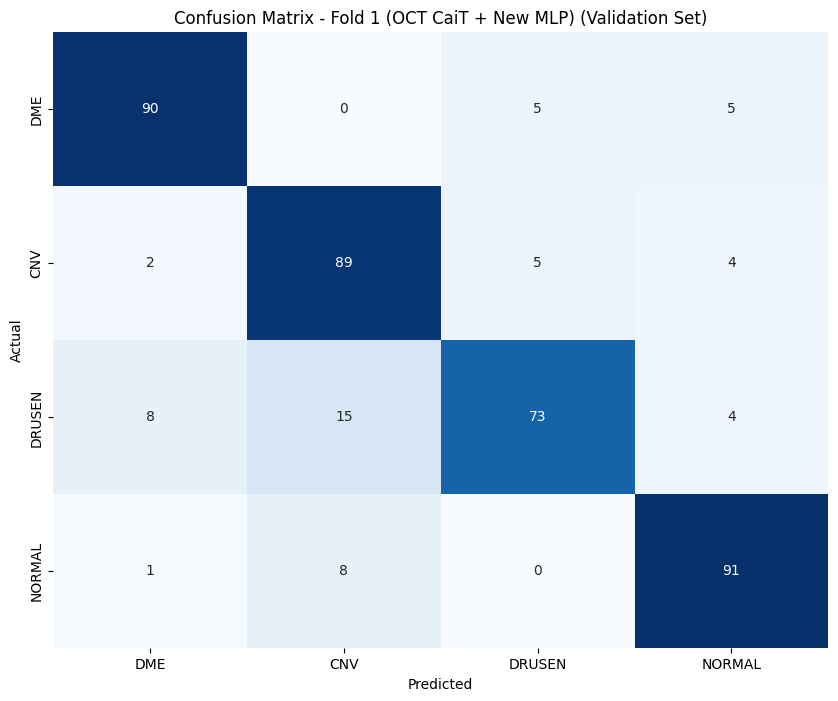

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9400826446280992
Test Precision -> 0.9414399678604224
Test Recall -> 0.9400826446280992
Test F1 Score -> 0.9401221453655633
Test AUC-ROC Score -> 0.99291088951119


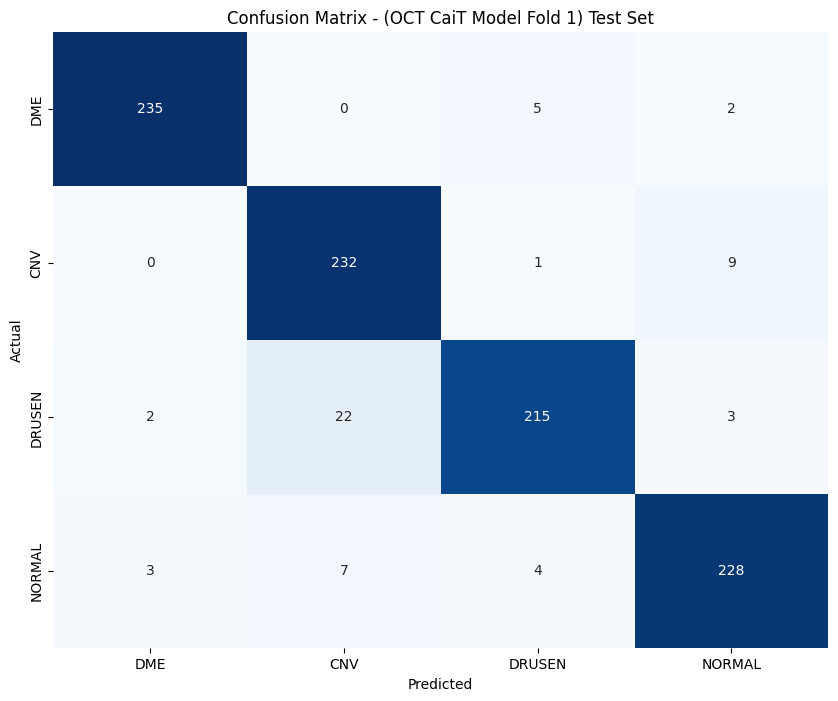

(0.9400826446280992,
 0.9414399678604224,
 0.9400826446280992,
 0.9401221453655633,
 0.99291088951119)

In [25]:
FOLD_TO_ACCESS = 1
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT CaiT Model Fold 1', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 2

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9546       0.7050      0.7045        0.6763             0.7180          0.7050           0.9199     +  0.0010  60.8914
      2        0.6550       0.7775      0.7794        0.5785             0.7837          0.7775           0.9390     +  0.0010  58.5862
      3        0.5652       0.7875      0.7886        0.5392             0.7915          0.7875           0.9473     +  0.0010  58.6820
      4        0.5194       0.8050      0.8066        0.5130             0.8115          0.8050           0.9523     +  0.0010  58.5332
      5        0.4988       0.8100      0.8107        0.4813             0.8152          0.8100           0.9573     +  0.0010  58.5179
      6        0.4642       0.7850      0.7827  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 2 -> 0.8475
Validation Precision for Fold 2 -> 0.8477170506301547
Validation Recall for Fold 2 -> 0.8475
Validation F1 Score for Fold 2 -> 0.846835609100152
Validation AUC-ROC Score for Fold 2 -> 0.9656
Metrics for each fold saved to OCT CaiT + New MLP_validation_results.csv
[[90  1  6  3]
 [ 0 89  9  2]
 [ 9 12 75  4]
 [ 8  3  4 85]]


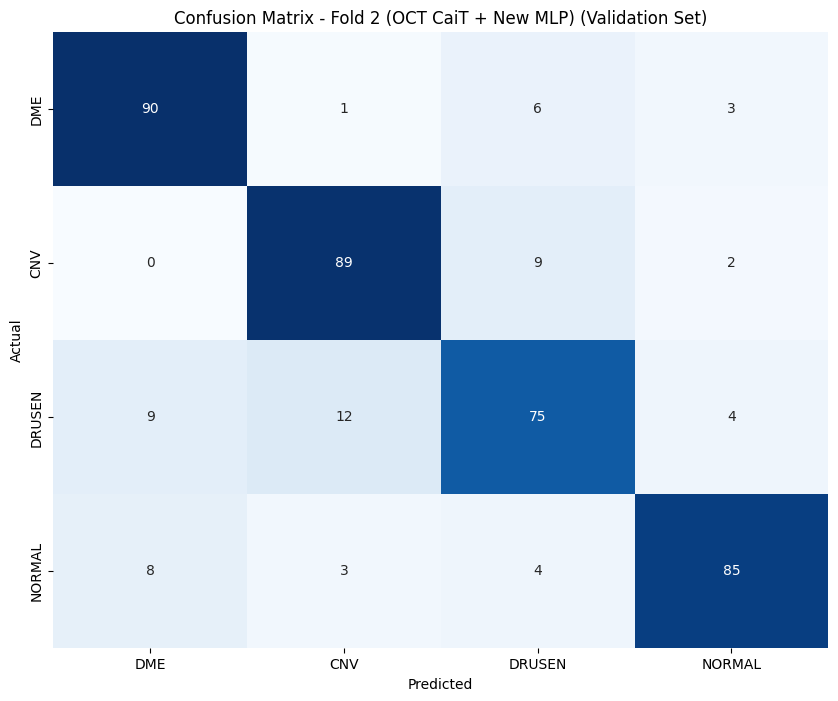

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9256198347107438
Test Precision -> 0.9288410628517322
Test Recall -> 0.9256198347107438
Test F1 Score -> 0.9257657331015086
Test AUC-ROC Score -> 0.9931727113357467


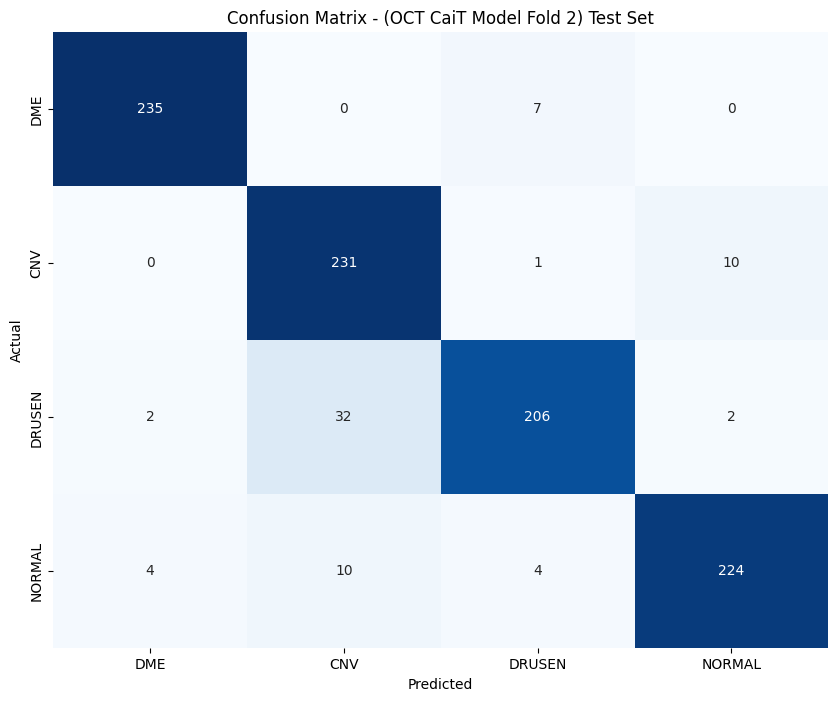

(0.9256198347107438,
 0.9288410628517322,
 0.9256198347107438,
 0.9257657331015086,
 0.9931727113357467)

In [26]:
FOLD_TO_ACCESS = 2
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT CaiT Model Fold 2', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 3

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9582       0.7500      0.7526        0.6385             0.7572          0.7500           0.9287     +  0.0010  57.8997
      2        0.6496       0.7800      0.7821        0.5564             0.7895          0.7800           0.9452     +  0.0010  56.1655
      3        0.5519       0.8050      0.8074        0.5157             0.8125          0.8050           0.9534     +  0.0010  55.7999
      4        0.5259       0.8225      0.8215        0.5196             0.8344          0.8225           0.9543     +  0.0010  55.8876
      5        0.4877       0.8175      0.8208        0.4703             0.8314          0.8175           0.9602        0.0010  55.7733
      6        0.4738       0.8200      0.8194  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 3 -> 0.8675
Validation Precision for Fold 3 -> 0.8679511998856118
Validation Recall for Fold 3 -> 0.8675
Validation F1 Score for Fold 3 -> 0.8672030495649599
Validation AUC-ROC Score for Fold 3 -> 0.9748166666666667
Metrics for each fold saved to OCT CaiT + New MLP_validation_results.csv
[[88  0  3  9]
 [ 1 90  7  2]
 [12  7 79  2]
 [ 5  1  4 90]]


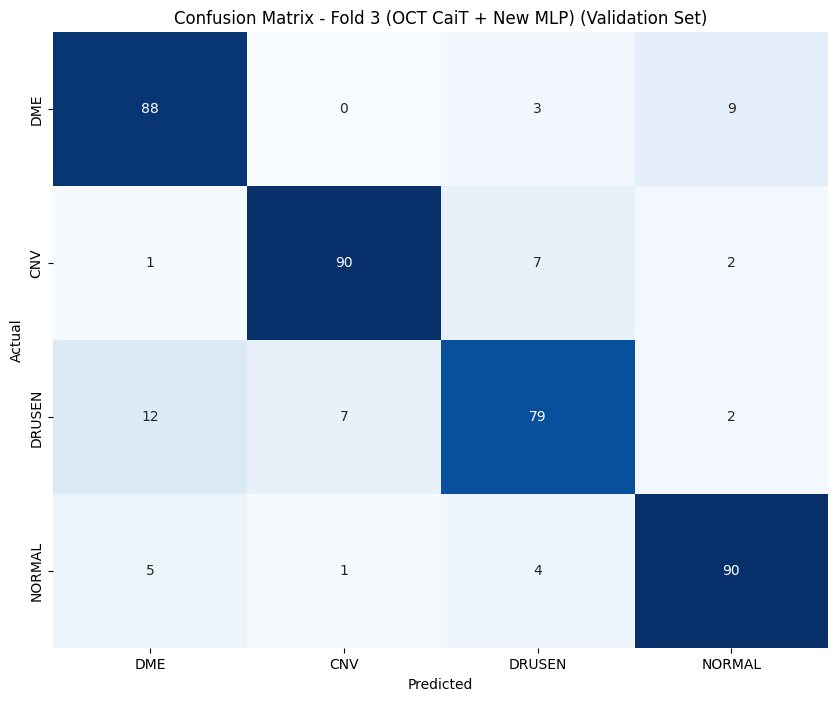

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9504132231404959
Test Precision -> 0.950526372251028
Test Recall -> 0.950413223140496
Test F1 Score -> 0.9503307419375093
Test AUC-ROC Score -> 0.9950566901167954


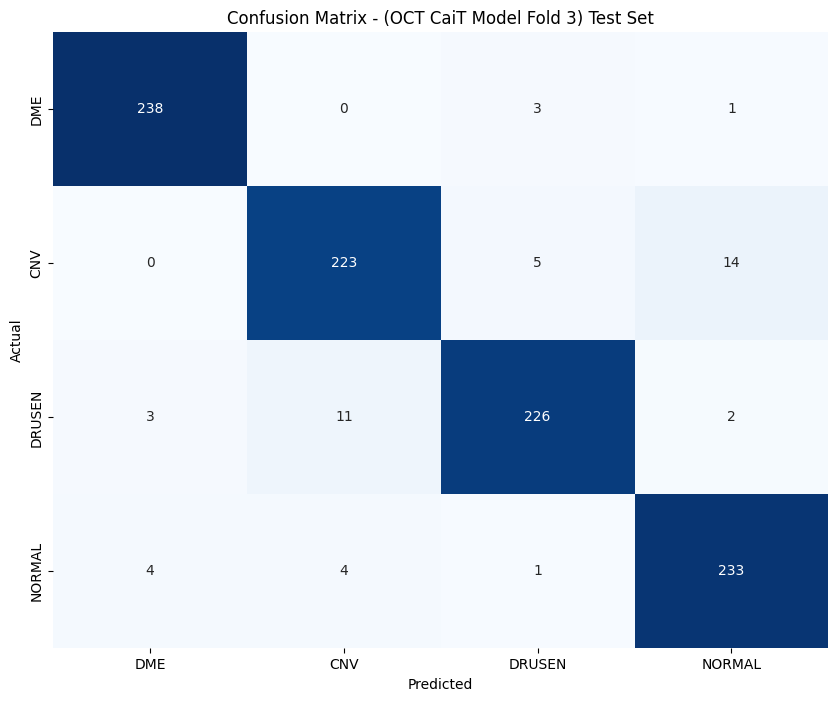

(0.9504132231404959,
 0.950526372251028,
 0.950413223140496,
 0.9503307419375093,
 0.9950566901167954)

In [27]:
FOLD_TO_ACCESS = 3
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT CaiT Model Fold 3', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 4

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9319       0.7250      0.7049        0.7229             0.7241          0.7250           0.9153     +  0.0010  58.2359
      2        0.6421       0.7825      0.7726        0.6057             0.7900          0.7825           0.9370     +  0.0010  56.1146
      3        0.5702       0.8000      0.7973        0.5579             0.8011          0.8000           0.9423     +  0.0010  55.9353
      4        0.5213       0.8100      0.8077        0.5163             0.8126          0.8100           0.9490     +  0.0010  55.8323
      5        0.4959       0.8225      0.8205        0.5064             0.8342          0.8225           0.9515     +  0.0010  55.6767
      6        0.4668       0.7975      0.7922  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 4 -> 0.86
Validation Precision for Fold 4 -> 0.8611356865577322
Validation Recall for Fold 4 -> 0.86
Validation F1 Score for Fold 4 -> 0.860235706788861
Validation AUC-ROC Score for Fold 4 -> 0.9716666666666666
Metrics for each fold saved to OCT CaiT + New MLP_validation_results.csv
[[88  0  9  3]
 [ 1 86  9  4]
 [10  8 80  2]
 [ 7  1  2 90]]


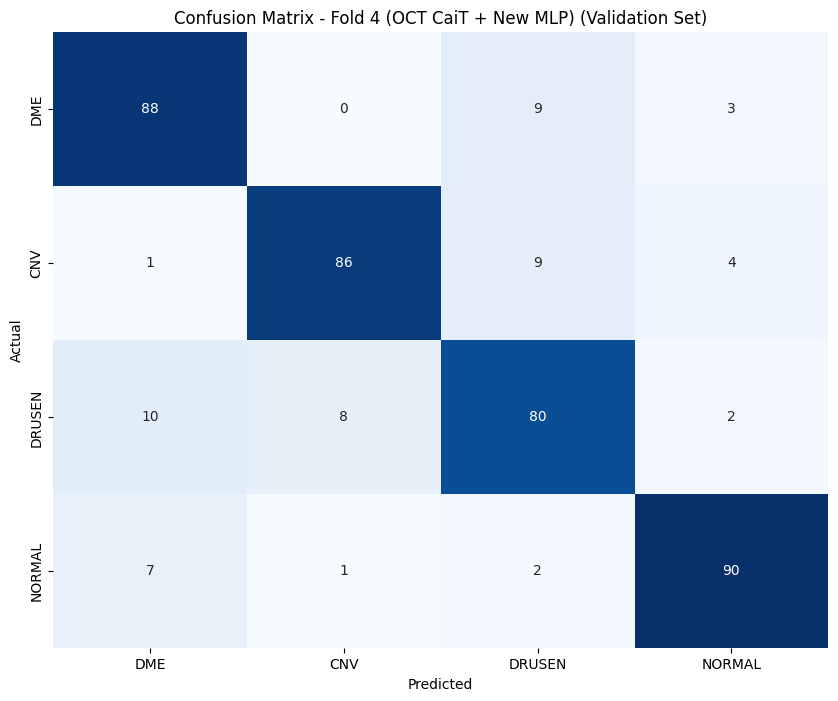

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9504132231404959
Test Precision -> 0.9504702740469982
Test Recall -> 0.9504132231404958
Test F1 Score -> 0.9504027445867397
Test AUC-ROC Score -> 0.9948930514764474


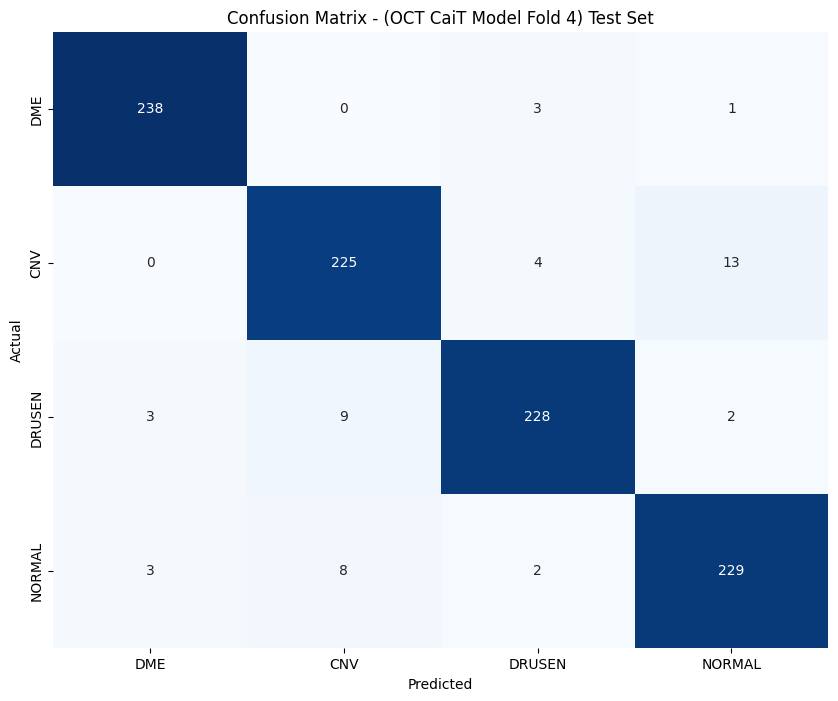

(0.9504132231404959,
 0.9504702740469982,
 0.9504132231404958,
 0.9504027445867397,
 0.9948930514764474)

In [28]:
FOLD_TO_ACCESS = 4
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT CaiT Model Fold 4', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 5

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9661       0.7500      0.7475        0.6458             0.7518          0.7500           0.9308     +  0.0010  58.7233
      2        0.6537       0.7700      0.7639        0.6013             0.7855          0.7700           0.9389     +  0.0010  56.1316
      3        0.5642       0.7750      0.7704        0.5646             0.7796          0.7750           0.9438     +  0.0010  55.8609
      4        0.5345       0.7800      0.7745        0.5570             0.7880          0.7800           0.9468     +  0.0010  55.6991
      5        0.4994       0.7825      0.7792        0.5423             0.7869          0.7825           0.9492     +  0.0010  55.7715
      6        0.4611       0.8025      0.7982  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 5 -> 0.865
Validation Precision for Fold 5 -> 0.8665102250516313
Validation Recall for Fold 5 -> 0.865
Validation F1 Score for Fold 5 -> 0.8645208161180665
Validation AUC-ROC Score for Fold 5 -> 0.972575
Metrics for each fold saved to OCT CaiT + New MLP_validation_results.csv
[[86  1  3 10]
 [ 1 91  4  4]
 [ 9  8 79  4]
 [ 5  3  2 90]]


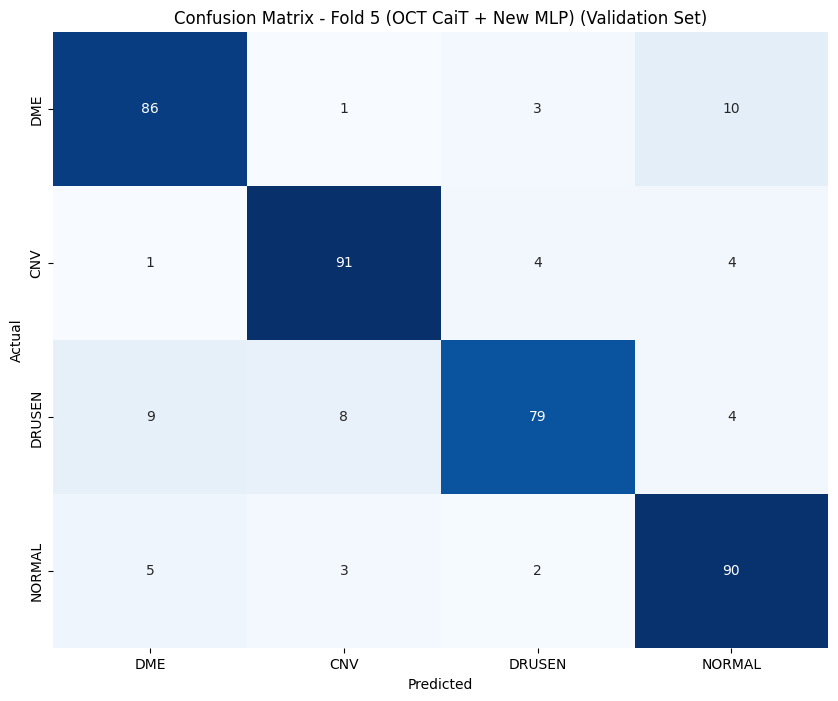

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9473140495867769
Test Precision -> 0.9476083445285575
Test Recall -> 0.9473140495867769
Test F1 Score -> 0.9473247247280199
Test AUC-ROC Score -> 0.9931342918288824


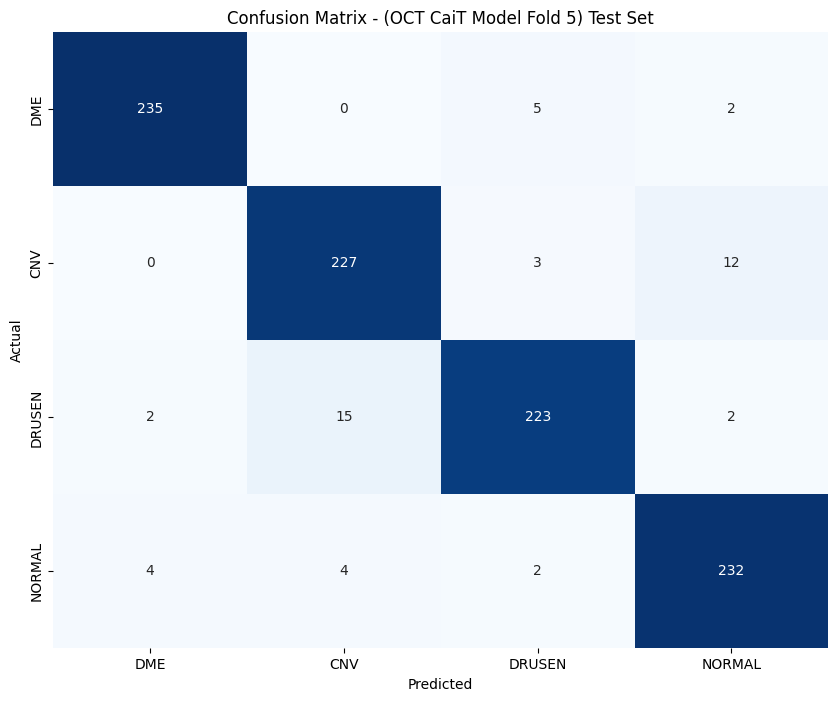

(0.9473140495867769,
 0.9476083445285575,
 0.9473140495867769,
 0.9473247247280199,
 0.9931342918288824)

In [29]:
FOLD_TO_ACCESS = 5
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT CaiT Model Fold 5', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 6

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9550       0.7150      0.7011        0.7017             0.7181          0.7150           0.9144     +  0.0010  58.2248
      2        0.6444       0.7350      0.7339        0.6269             0.7430          0.7350           0.9272     +  0.0010  55.8282
      3        0.5837       0.7325      0.7286        0.6256             0.7450          0.7325           0.9298        0.0010  55.7330
      4        0.5362       0.7700      0.7696        0.5741             0.7759          0.7700           0.9387     +  0.0010  55.5255
      5        0.5084       0.7400      0.7346        0.5899             0.7446          0.7400           0.9384        0.0010  55.9183
      6        0.4620       0.7775      0.7652  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 6 -> 0.845
Validation Precision for Fold 6 -> 0.843936294268381
Validation Recall for Fold 6 -> 0.845
Validation F1 Score for Fold 6 -> 0.8439007410680142
Validation AUC-ROC Score for Fold 6 -> 0.9664416666666666
Metrics for each fold saved to OCT CaiT + New MLP_validation_results.csv
[[91  0  7  2]
 [ 0 88  9  3]
 [13 10 72  5]
 [ 2  6  5 87]]


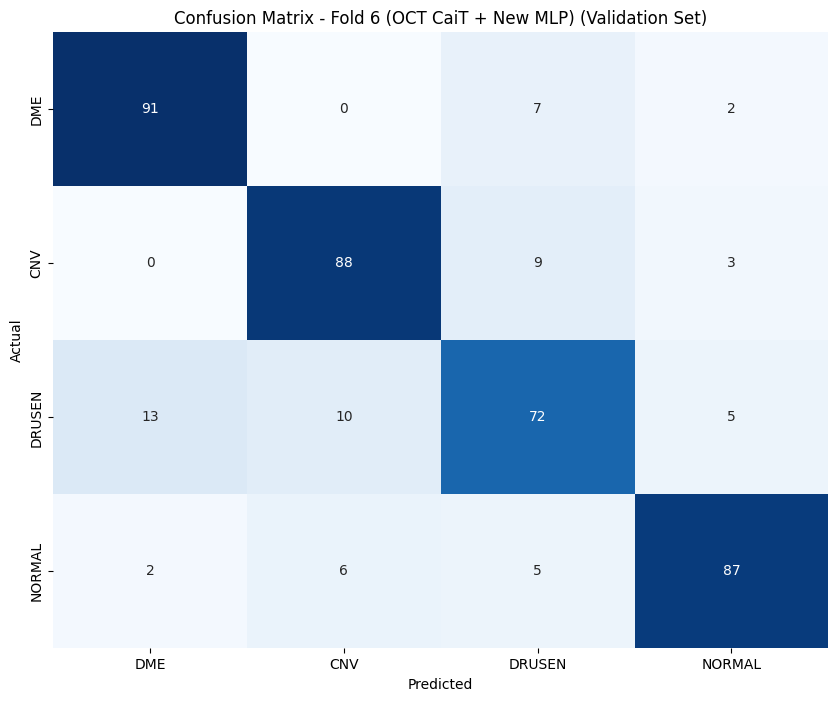

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9380165289256198
Test Precision -> 0.9383913754234721
Test Recall -> 0.9380165289256199
Test F1 Score -> 0.9379610355602108
Test AUC-ROC Score -> 0.9933377729207933


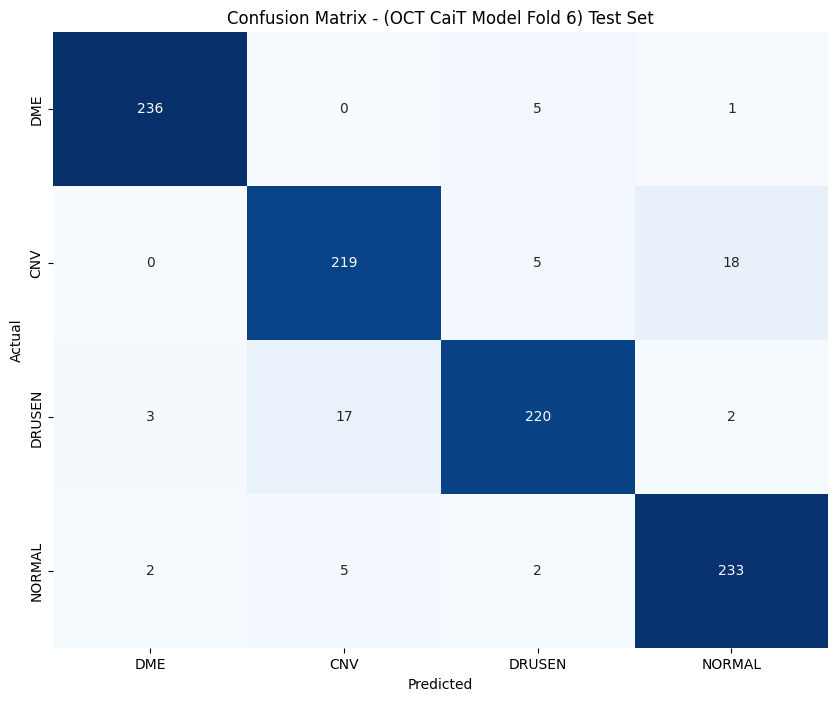

(0.9380165289256198,
 0.9383913754234721,
 0.9380165289256199,
 0.9379610355602108,
 0.9933377729207933)

In [30]:
FOLD_TO_ACCESS = 6
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT CaiT Model Fold 6', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 7

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9536       0.7200      0.7133        0.7069             0.7160          0.7200           0.9111     +  0.0010  58.3733
      2        0.6451       0.7500      0.7463        0.6048             0.7536          0.7500           0.9363     +  0.0010  55.8007
      3        0.5617       0.7750      0.7688        0.5592             0.7753          0.7750           0.9453     +  0.0010  55.6951
      4        0.5294       0.7725      0.7723        0.5461             0.7777          0.7725           0.9480        0.0010  55.8631
      5        0.4916       0.7875      0.7868        0.5297             0.7961          0.7875           0.9535     +  0.0010  55.8216
      6        0.4664       0.7850      0.7798  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 7 -> 0.8175
Validation Precision for Fold 7 -> 0.8197461261504584
Validation Recall for Fold 7 -> 0.8175
Validation F1 Score for Fold 7 -> 0.8162165300317804
Validation AUC-ROC Score for Fold 7 -> 0.9645166666666667
Metrics for each fold saved to OCT CaiT + New MLP_validation_results.csv
[[83  1  7  9]
 [ 0 90  7  3]
 [10 19 69  2]
 [ 3  8  4 85]]


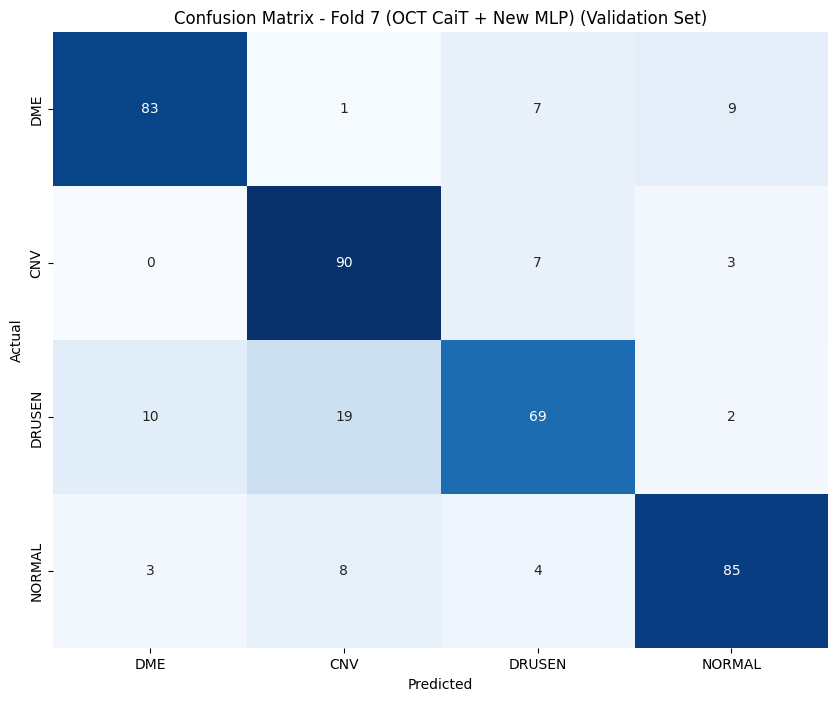

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9049586776859504
Test Precision -> 0.9112079905193156
Test Recall -> 0.9049586776859504
Test F1 Score -> 0.9050058597495232
Test AUC-ROC Score -> 0.9906740204448694


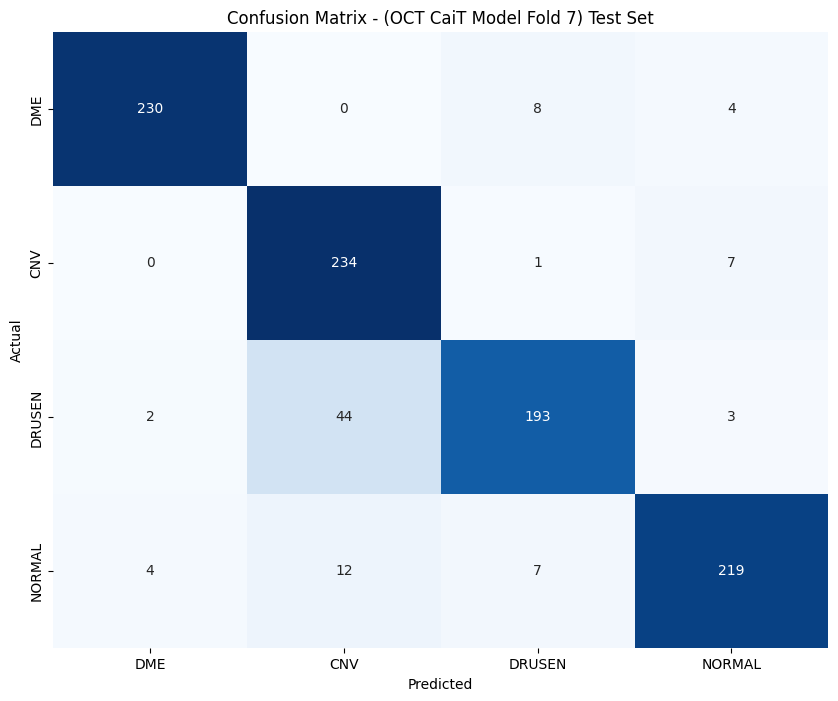

(0.9049586776859504,
 0.9112079905193156,
 0.9049586776859504,
 0.9050058597495232,
 0.9906740204448694)

In [31]:
FOLD_TO_ACCESS = 7
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT CaiT Model Fold 7', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 8

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9412       0.7300      0.7246        0.7562             0.7244          0.7300           0.9009     +  0.0010  58.7129
      2        0.6508       0.7125      0.7162        0.6772             0.7295          0.7125           0.9165        0.0010  55.8895
      3        0.5795       0.7475      0.7492        0.6386             0.7599          0.7475           0.9261     +  0.0010  55.5331
      4        0.5234       0.7500      0.7545        0.6093             0.7665          0.7500           0.9325     +  0.0010  55.8013
      5        0.4957       0.7475      0.7516        0.6031             0.7617          0.7475           0.9339        0.0010  55.8786
      6        0.4501       0.7325      0.7332  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 8 -> 0.785
Validation Precision for Fold 8 -> 0.7861852665371294
Validation Recall for Fold 8 -> 0.7850000000000001
Validation F1 Score for Fold 8 -> 0.7796242657085363
Validation AUC-ROC Score for Fold 8 -> 0.945675
Metrics for each fold saved to OCT CaiT + New MLP_validation_results.csv
[[80  0 10 10]
 [ 0 88 10  2]
 [ 8 26 55 11]
 [ 1  6  2 91]]


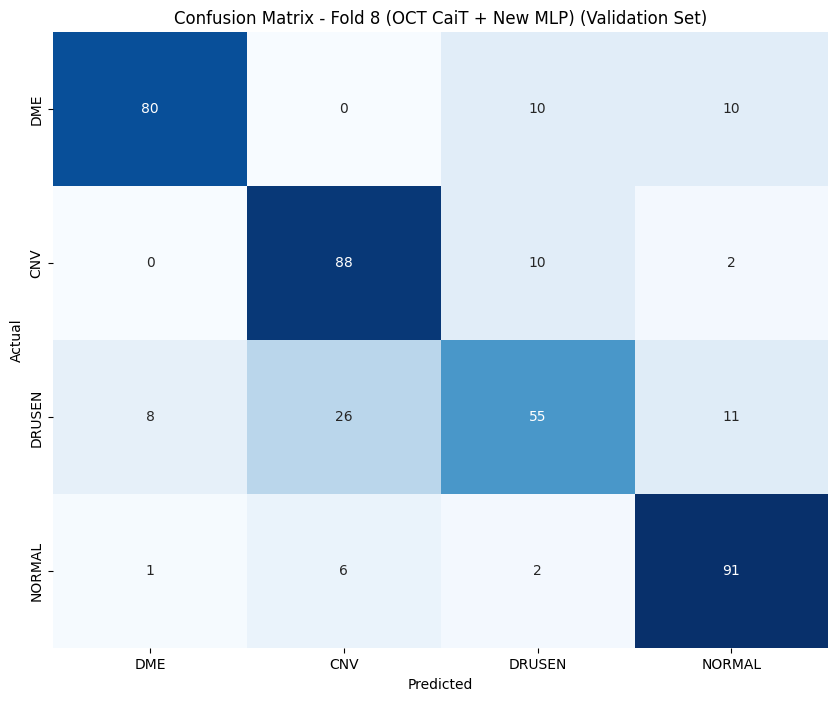

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9152892561983471
Test Precision -> 0.9198640856551606
Test Recall -> 0.9152892561983471
Test F1 Score -> 0.9148829810367504
Test AUC-ROC Score -> 0.9906996334494457


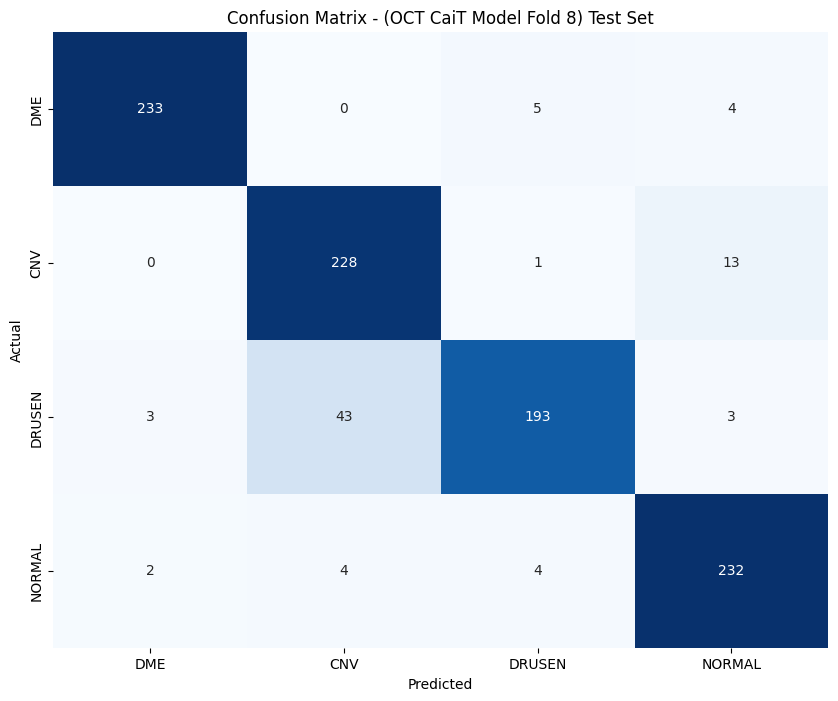

(0.9152892561983471,
 0.9198640856551606,
 0.9152892561983471,
 0.9148829810367504,
 0.9906996334494457)

In [32]:
FOLD_TO_ACCESS = 8
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT CaiT Model Fold 8', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 9

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9434       0.7125      0.7147        0.7075             0.7254          0.7125           0.9116     +  0.0010  58.2144
      2        0.6666       0.7400      0.7332        0.6389             0.7558          0.7400           0.9325     +  0.0010  55.8542
      3        0.5700       0.8000      0.7995        0.5731             0.8127          0.8000           0.9445     +  0.0010  55.6205
      4        0.5311       0.8225      0.8239        0.5308             0.8377          0.8225           0.9505     +  0.0010  55.8140
      5        0.5072       0.8325      0.8313        0.5084             0.8341          0.8325           0.9534     +  0.0010  55.7650
      6        0.4735       0.8075      0.8021  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 9 -> 0.88
Validation Precision for Fold 9 -> 0.8820976900245192
Validation Recall for Fold 9 -> 0.88
Validation F1 Score for Fold 9 -> 0.8784173143929243
Validation AUC-ROC Score for Fold 9 -> 0.966725
Metrics for each fold saved to OCT CaiT + New MLP_validation_results.csv
[[91  0  3  6]
 [ 1 94  2  3]
 [ 8 10 75  7]
 [ 5  1  2 92]]


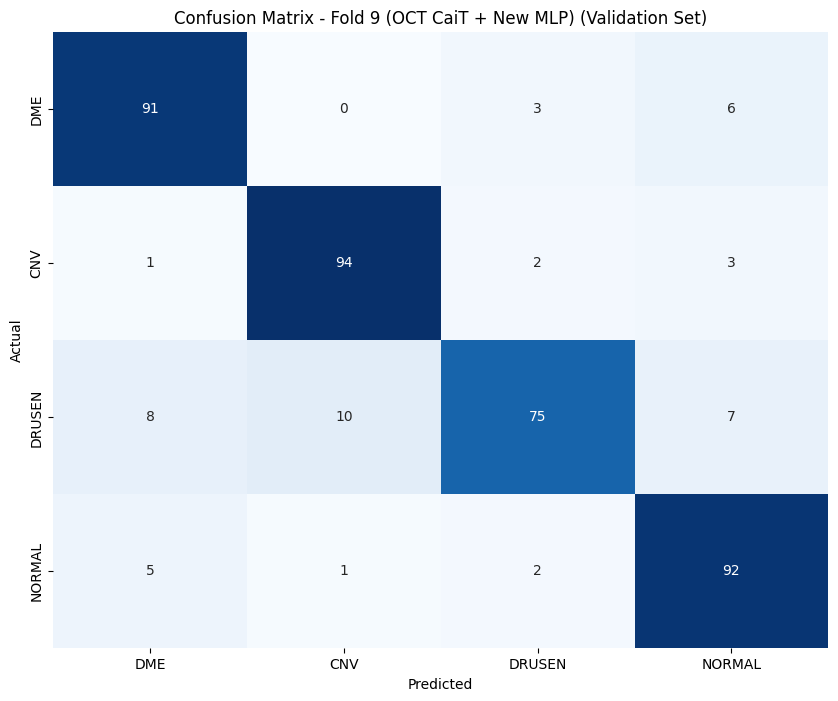

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9369834710743802
Test Precision -> 0.9378865083430914
Test Recall -> 0.9369834710743802
Test F1 Score -> 0.9369050940156536
Test AUC-ROC Score -> 0.9939411014730323


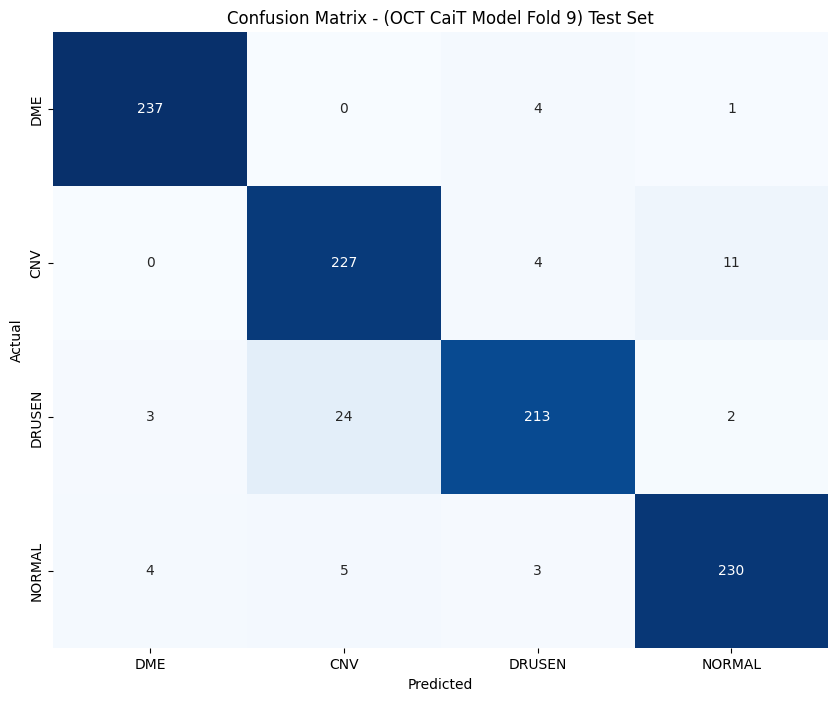

(0.9369834710743802,
 0.9378865083430914,
 0.9369834710743802,
 0.9369050940156536,
 0.9939411014730323)

In [33]:
FOLD_TO_ACCESS = 9
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT CaiT Model Fold 9', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

### Train Fold 10

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


  epoch    train_loss    valid_acc    valid_f1    valid_loss    valid_precision    valid_recall    valid_roc_auc    cp      lr      dur
-------  ------------  -----------  ----------  ------------  -----------------  --------------  ---------------  ----  ------  -------
      1        0.9337       0.7225      0.7198        0.7096             0.7359          0.7225           0.9165     +  0.0010  58.2411
      2        0.6419       0.7750      0.7712        0.6273             0.7749          0.7750           0.9310     +  0.0010  56.2768
      3        0.5578       0.7900      0.7904        0.5944             0.7932          0.7900           0.9372     +  0.0010  55.9620
      4        0.5317       0.7875      0.7869        0.5692             0.7895          0.7875           0.9412        0.0010  56.2191
      5        0.4899       0.7850      0.7838        0.5837             0.7989          0.7850           0.9445        0.0010  55.7598
      6        0.4612       0.7850      0.7838  

Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Validation Accuracy for Fold 10 -> 0.8225
Validation Precision for Fold 10 -> 0.825317477430855
Validation Recall for Fold 10 -> 0.8225
Validation F1 Score for Fold 10 -> 0.8212991021112491
Validation AUC-ROC Score for Fold 10 -> 0.9532333333333334
Metrics for each fold saved to OCT CaiT + New MLP_validation_results.csv
[[86  4  4  6]
 [ 0 91  9  0]
 [ 8 19 69  4]
 [ 6  5  6 83]]


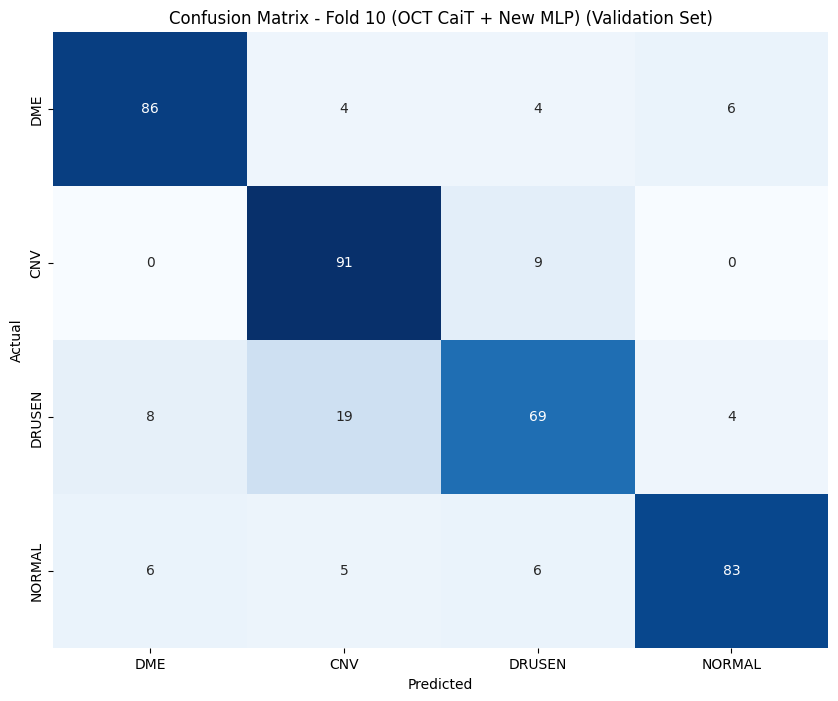

Re-initializing module because the following parameters were re-set: output_features.


Using cache found in C:\Users\Owner/.cache\torch\hub\facebookresearch_deit_main


Re-initializing criterion.
Re-initializing optimizer.
Test Accuracy -> 0.9256198347107438
Test Precision -> 0.9284460118843085
Test Recall -> 0.9256198347107438
Test F1 Score -> 0.925893457833759
Test AUC-ROC Score -> 0.9908234296382306


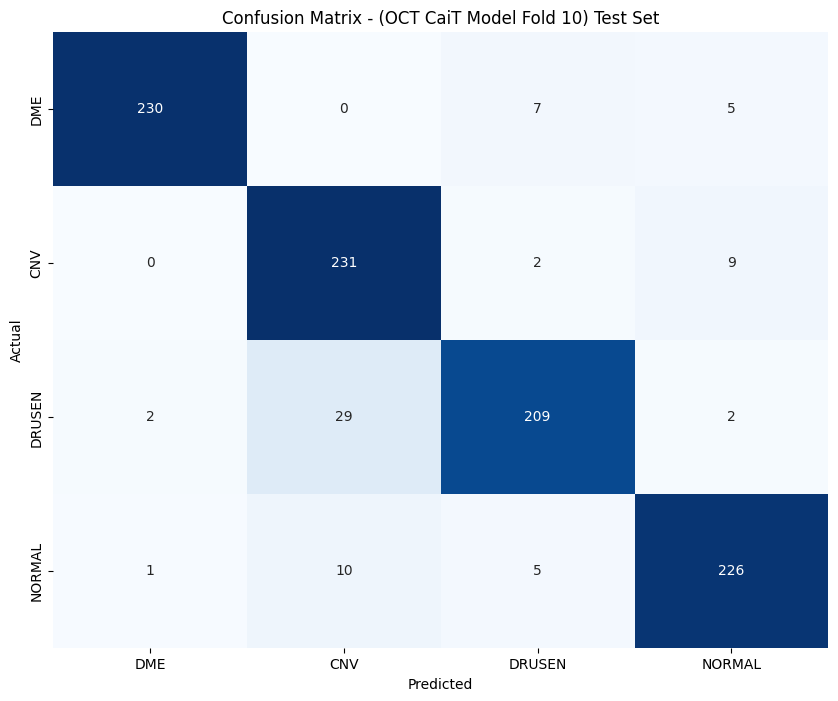

(0.9256198347107438,
 0.9284460118843085,
 0.9256198347107438,
 0.925893457833759,
 0.9908234296382306)

In [34]:
FOLD_TO_ACCESS = 10
checkpoint, model = train_and_evaluate_model(NAME_OF_EXPERIMENT, FOLD_TO_ACCESS, NEURAL_NETWORK_CONFIG, Model, predefined_split, class_names, csv_file, metrics_per_fold, trained_models)
get_metrics(model, TEST, 'OCT CaiT Model Fold 10', classification_type='multiclass', data_type='test', checkpoint_path=checkpoint) # For test set

## Average validation performance metrics across all folds

In [35]:
# Calculating the average validation performance metrics across all folds
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1 = np.mean(f1_scores)
average_auc_roc = np.mean(auc_roc_scores)

# Displaying the average validation performance metrics across all folds
print(f'Average Validation Accuracy across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_accuracy}')
print(f'Average Validation Precision across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_precision}')
print(f'Average Validation Recall across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_recall}')
print(f'Average Validation F1 Score across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_f1}')
print(f'Average Validation AUC ROC Score across {NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS} Folds -> {average_auc_roc}')


# Creating a dataframe that contains the average validation performance metrics
average_performance_metrics = pd.DataFrame({
    'Model_Name': [NAME_OF_EXPERIMENT],
    'Number of Folds': [NEURAL_NETWORK_CONFIG.NUMBER_OF_FOLDS],
    'Average Validation Accuracy': [average_accuracy],
    'Average Validation Precision': [average_precision],
    'Average Validation Recall': [average_recall],
    'Average Validation F1 Score': [average_f1],
    'Average Validation AUC-ROC': [average_auc_roc]
})

# Save the dataframe that contains the average validation performance metrics to CSV
average_performance_metrics.to_csv(f'{NAME_OF_EXPERIMENT}_average_validation_results.csv', index=False)


Average Validation Accuracy across 10 Folds -> 0.84475
Average Validation Precision across 10 Folds -> 0.84606595261222
Average Validation Recall across 10 Folds -> 0.84475
Average Validation F1 Score across 10 Folds -> 0.8434532159875671
Average Validation AUC ROC Score across 10 Folds -> 0.9650183333333333
